In [100]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import seaborn as sns
pd.set_option('display.max_rows', 250)

### arxiv

In [107]:
!cd ..;python parse_tb.py

### LM & curriculum


In [115]:
res_df = pd.read_csv('../results/arxiv.csv')

In [116]:
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna('NA')
res_df.max_n_segments = res_df.max_n_segments.fillna('NA')
res_df.k2 = res_df.k2.fillna(-1)
res_df['eval_segment'] = res_df.max_n_segments

In [120]:
res_df[res_df.model_path.apply(lambda x: 'sp' in x) ].model_path.iloc[-1]

'../runs/arxiv/gpt2/linear_adamw_wd1e-03_5100-1024-5x1024_mem2_bs32_regular_bptt-5_from_cpt_cv2_sp2e-1_4-5/run_1'

In [125]:
res_df_sp = res_df[res_df.model_path.apply(lambda x: 'sp' in x and 'eval' in x)]
res_df_cv2 = res_df[res_df.model_path.apply(lambda x: 'cv2' in x)]
res_df = res_df[res_df.model_path.apply(lambda x: 'cv2' not in x)]

In [112]:
# res_df_cv2[['max_n_segments', 'eval_segment']]

In [128]:
# res_df['checkpoint_segment'] = res_df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0] if 'from_cpt_' in x else -1).astype(int)
# res_df_cv2['checkpoint_segment'] = res_df_cv2.model_path.apply(lambda x: x.split('from_cpt_cv2_')[1].split('-')[0] if 'from_cpt_cv2_' in x else -1).astype(int)
res_df_sp['checkpoint_segment'] = res_df_sp.model_path.apply(lambda x: x.split('from_cpt_cv2_sp2e-1_')[1].split('-')[0] if 'from_cpt_cv2_sp2e-1_' in x else -1).astype(int)


In [9]:
def bpb(loss, ltlb=0.3532):
    return ltlb * loss / np.log(2)

def perplexity(loss):
    return np.exp(loss)

### Memory effect

In [36]:
slc = res_df[(res_df.from_pretrained == "EleutherAI/pythia-70m-deduped") & (res_df.num_mem_tokens != 'NA') & (res_df.num_steps > 0) & (res_df.max_n_segments.isin({1, 2}))]
# slc.model_path.values

In [38]:
gb_cols = ['max_n_segments', 'num_mem_tokens']
metric_col = 'best_valid_loss'
gb = slc.groupby(gb_cols)[[metric_col]].mean(metric_col)


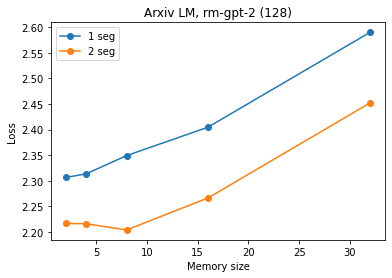

In [45]:
max_n_segmentss = list(range(1, 3))
for max_n_segments in max_n_segmentss:
    s = gb.reset_index()
    s = s[s.max_n_segments == max_n_segments].sort_values('num_mem_tokens')
    plt.plot(s.num_mem_tokens, s.best_valid_loss, marker='o')
    
plt.legend([f"{s} seg" for s in max_n_segmentss])
plt.xlabel('Memory size')
plt.ylabel("Loss")
plt.title("Arxiv LM, rm-gpt-2 (128)")
plt.show()

### compare to PILE scores

In [71]:
import numpy

In [72]:
#1024 no ft, 1024 ft
bpb(2.926), bpb(1.658)

(1.4909722335812392, 0.8448502950368059)

In [73]:
#128 no ft, 128 ft
bpb(3.469), bpb(2.213)

(1.7676632530052352, 1.1276560331221062)

### 1024

In [15]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x)].copy()
df = df[(df.num_mem_tokens == 2) & (df.input_size == 1024)]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.213
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table - baseline_score
# table

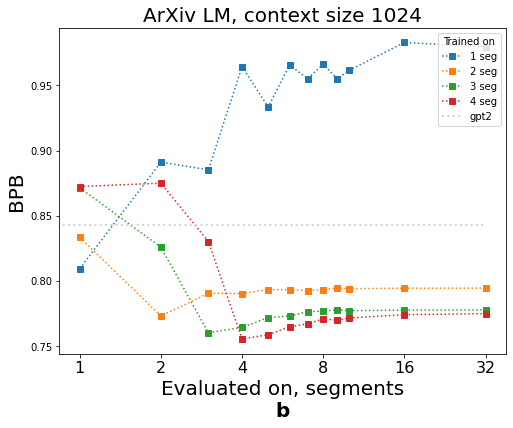

In [19]:
# custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
# sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


baseline_loss = 1.654

tab = table.apply(bpb)[table.columns[:12]]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('BPB', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('ArXiv LM, context size 1024', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
# plt.ylim(-15, 15)
plt.hlines(bpb(baseline_loss), 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)
models = [f'{i} seg' for i in list(tab.index)] + ['gpt2']
plt.legend(models, title='Trained on', loc='upper right')
plt.savefig('img/extrapolate_lm_1024_abs.pdf', format='pdf', bbox_inches='tight')
plt.show()

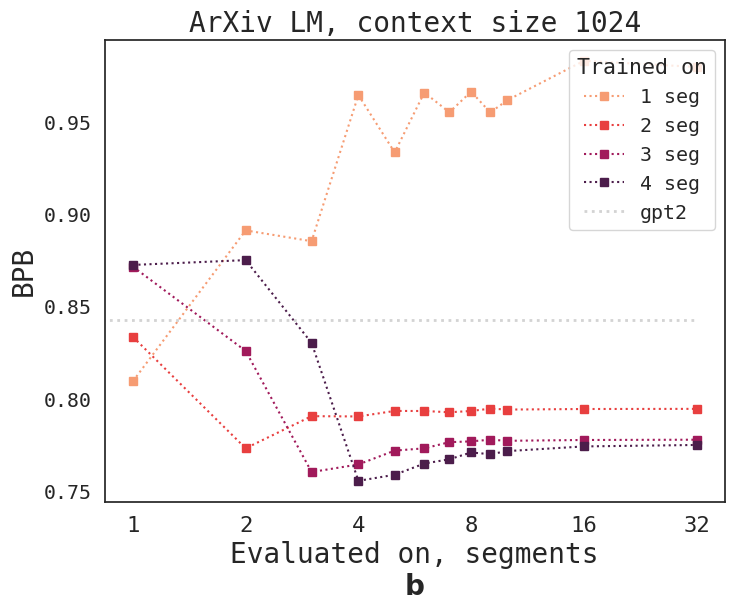

In [ ]:
custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


baseline_loss = 1.654

tab = table.apply(bpb)[table.columns[:12]]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('BPB', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('ArXiv LM, context size 1024', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
# plt.ylim(-15, 15)
plt.hlines(bpb(baseline_loss), 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)
models = [f'{i} seg' for i in list(tab.index)] + ['gpt2']
plt.legend(models, title='Trained on', loc='upper right')
plt.savefig('img/extrapolate_lm_1024_abs.pdf', format='pdf', bbox_inches='tight')
plt.show()

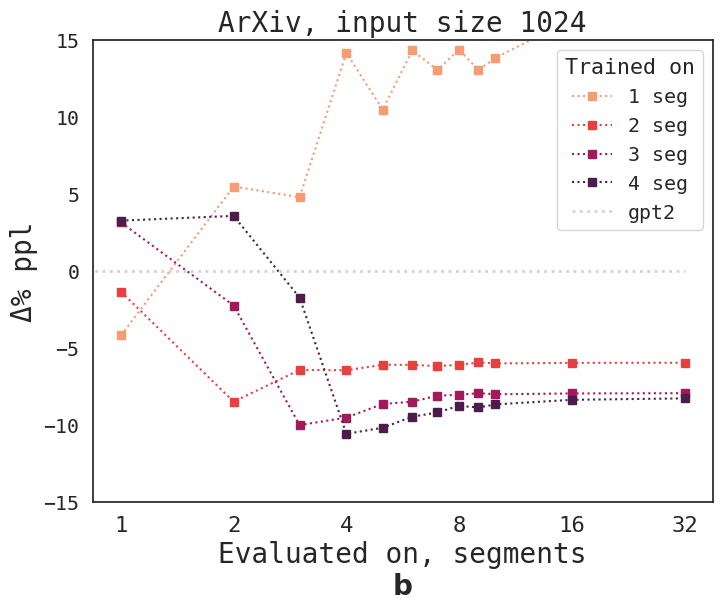

In [366]:
custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


baseline_score = 1.658
tab = (table - baseline_score) / baseline_score * 100
tab = tab[tab.columns[:12]]
# tab = table
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('Δ% ppl', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('ArXiv LM, input size 1024', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.ylim(-15, 15)
plt.hlines(0, 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)
models = [f'{i} seg' for i in list(tab.index)] + ['gpt2']
plt.legend(models, title='Trained on', loc='upper right')
plt.savefig('img/extrapolate_lm_1024.pdf', format='pdf', bbox_inches='tight')
plt.show()